# Load packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

# Load Dataset

In [77]:
data = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/4.Fraud/Fraud.csv',parse_dates=['signup_time','purchase_time']) 
data.drop(data.columns[[0]],axis=1,inplace=True)
print(data.head())
print(data.shape)

   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
(151112, 11)


In [23]:
ip_country = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/4.Fraud/IpAddress_to_Country')
ip_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


# Check duplicates in user id

In [78]:
len(set(data['user_id'])) - data.shape[0]

0

# Add the country to the original data set by using the ip address

In [50]:
country = []
for i in range(len(data)):
    ip_i = data['ip_address'][i]
    tmp = ip_country[(ip_country['lower_bound_ip_address'] <= ip_i) & (ip_country['upper_bound_ip_address'] >= ip_i)]  
    if len(tmp) == 1:
        country.append(tmp['country'].values[0])
    else:
        country.append('NA')
 

In [79]:
data['country'] = country

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


# Feature Engineering

#### • time difference between sign-up time and purchase time
#### • check for each device id how many different users had it
#### • check for each ip address how many different users had it
#### • day of the week
#### • week of the yr


In [80]:
# Get the time difference between purchase time and signup time
time_diff = data['purchase_time'] -  data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [81]:
# Check user number for unique devices
device_num = data[['user_id','device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
data = data.merge(device_num, how='left', on='device_id')
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1


In [86]:
# Check user number for unique ip_address
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,8
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1


In [87]:
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,8,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [90]:
# Define features and target to be used
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,8,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


# Fraudulent Activity Identification

In [91]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_331"; Java(TM) SE Runtime Environment (build 1.8.0_331-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.331-b09, mixed mode)
  Starting server from /opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/nt/z1npcmws4ld703g3hhm7p1p00000gn/T/tmpgq46u5i8
  JVM stdout: /var/folders/nt/z1npcmws4ld703g3hhm7p1p00000gn/T/tmpgq46u5i8/h2o_kexinluo_started_from_python.out
  JVM stderr: /var/folders/nt/z1npcmws4ld703g3hhm7p1p00000gn/T/tmpgq46u5i8/h2o_kexinluo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_kexinluo_ggckeh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [92]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

for name in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'country', 'class']:
    h2o_df[name] = h2o_df[name].asfactor()

h2o_df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
type,enum,int,enum,int,int,enum,enum,enum,int,enum,int,int,int,enum
mins,,1.0,,1.0,9.0,,,,18.0,,1.0,1.0,1.0,
mean,,16.50174043093856,,24.658571126052106,36.9353724389859,,,,33.14070358409671,,40942.584427444745,1.684366562549633,1.3041849753824974,
maxs,,34.0,,51.0,154.0,,,,76.0,,86399.0,20.0,13.0,
sigma,,9.814287461798912,,11.651556782719464,18.32276214866215,,,,8.617733490961479,,26049.66190211833,2.616953602804179,1.367267124545481,
zeros,,0,,0,0,,,,0,,0,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,9.0,5,16.0,34.0,SEO,Chrome,M,39.0,Japan,13882.0,1.0,1.0,0
1,6,23.0,0,24.0,16.0,Ads,Chrome,F,53.0,United States,17944.0,1.0,1.0,0
2,3,1.0,3,1.0,15.0,SEO,Opera,M,53.0,United States,1.0,12.0,8.0,1


In [96]:
# Split into 70% training and 30% test dataset
strat_split = h2o_df['class'].stratified_split(test_frac=0.3, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

# Define features and target
feature = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 
           'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num']
target = 'class'

In [97]:
# Build random forest model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1655744756882_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,22.0,22.0,1319648.0,20.0,20.0,20.0,2641.0,5151.0,3819.818




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11275272958932347
RMSE: 0.3357867323009107
LogLoss: 0.327318894345495
Mean Per-Class Error: 0.038032123702735225
AUC: 0.9940978329939185
AUCPR: 0.9939788616315376
Gini: 0.988195665987837

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.055594790325676484: 


,,0,1,Error,Rate
0,0,90641.0,5228.0,0.0545,(5228.0/95869.0)
1,1,2065.0,93841.0,0.0215,(2065.0/95906.0)
2,Total,92706.0,99069.0,0.038,(7293.0/191775.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.055595,0.962595,331.0
1,max f2,0.043192,0.976943,340.0
2,max f0point5,0.097461,0.962042,305.0
3,max accuracy,0.057413,0.962013,330.0
4,max precision,0.955808,0.999926,9.0
5,max recall,0.016397,1.000000,373.0
6,max specificity,1.000000,0.999958,0.0
7,max absolute_mcc,0.055595,0.924445,331.0
8,max min_per_class_accuracy,0.068369,0.958683,323.0
9,max mean_per_class_accuracy,0.057413,0.962010,330.0



Gains/Lift Table: Avg response rate: 50.01 %, avg score: 36.32 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.277776,1.000000,1.999454,1.999454,0.999925,1.000000,0.999925,1.000000,0.555400,0.555400,99.945366,99.945366,0.555359
1,2,0.299999,0.733884,1.995850,1.999187,0.998123,0.847048,0.999791,0.988670,0.044354,0.599754,99.585044,99.918674,0.599629
2,3,0.400002,0.237663,1.966866,1.991106,0.983628,0.441059,0.995750,0.851764,0.196693,0.796447,96.686614,99.110638,0.793046
3,4,0.500000,0.068277,1.626229,1.918132,0.813276,0.134927,0.959256,0.708399,0.162620,0.959066,62.622904,91.813244,0.918314
4,5,0.599998,0.027989,0.399754,1.665074,0.199917,0.041338,0.832702,0.597224,0.039975,0.999041,-60.024606,66.507375,0.798244
5,6,0.700001,0.018709,0.008654,1.428435,0.004328,0.022866,0.714359,0.515171,0.000865,0.999906,-99.134641,42.843525,0.599929
6,7,0.799999,0.012256,0.000417,1.249936,0.000209,0.015386,0.625092,0.452699,0.000042,0.999948,-99.958294,24.993646,0.399977
7,8,0.899997,0.005590,0.000000,1.111057,0.000000,0.009019,0.555639,0.403402,0.000000,0.999948,-100.000000,11.105705,0.199942
8,9,1.000000,0.000000,0.000521,1.000000,0.000261,0.001868,0.500099,0.363247,0.000052,1.000000,-99.947870,0.000000,0.000000




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.041193821212471005
RMSE: 0.20296261038051075
LogLoss: 0.19433955125901145
Mean Per-Class Error: 0.23523007241889854
AUC: 0.8396850971593849
AUCPR: 0.706209745187014
Gini: 0.6793701943187698

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4293283562173198: 


,,0,1,Error,Rate
0,0,41087.0,1.0,0.0,(1.0/41088.0)
1,1,1997.0,2248.0,0.4704,(1997.0/4245.0)
2,Total,43084.0,2249.0,0.0441,(1998.0/45333.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.429328,0.692331,10.0
1,max f2,0.045863,0.653295,201.0
2,max f0point5,0.508076,0.848893,7.0
3,max accuracy,0.429328,0.955926,10.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.000005,1.000000,399.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.429328,0.710464,10.0
8,max min_per_class_accuracy,0.023386,0.761837,270.0
9,max mean_per_class_accuracy,0.039703,0.813669,213.0



Gains/Lift Table: Avg response rate:  9.36 %, avg score:  7.01 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.048993,1.000000,10.679152,10.679152,1.000000,1.000000,1.000000,1.000000,0.523204,0.523204,967.915194,967.915194,0.523204
1,2,0.050008,0.287620,6.964664,10.603781,0.652174,0.637374,0.992942,0.992642,0.007067,0.530271,596.466431,960.378078,0.529881
2,3,0.100015,0.061095,2.416588,6.510184,0.226290,0.111351,0.609616,0.551996,0.120848,0.651119,141.658798,551.018438,0.608041
3,4,0.150001,0.032876,1.154630,4.725525,0.108120,0.041464,0.442500,0.381869,0.057715,0.708834,15.463029,372.552473,0.616569
4,5,0.200009,0.027801,0.353302,3.632349,0.033083,0.029978,0.340135,0.293886,0.017668,0.726502,-64.669766,263.234858,0.580887
5,6,0.300002,0.022783,0.388718,2.551218,0.036400,0.025015,0.238897,0.204269,0.038869,0.765371,-61.128170,155.121799,0.513448
6,7,0.399996,0.019490,0.343957,1.999433,0.032208,0.021077,0.187228,0.158474,0.034393,0.799764,-65.604320,99.943312,0.441071
7,8,0.500011,0.016742,0.350947,1.669692,0.032863,0.018086,0.156351,0.130392,0.035100,0.834865,-64.905301,66.969226,0.369449
8,9,0.600004,0.014213,0.365160,1.452286,0.034194,0.015479,0.135993,0.111242,0.036514,0.871378,-63.484038,45.228614,0.299411
9,10,0.699998,0.011669,0.336889,1.292954,0.031546,0.012939,0.121073,0.097199,0.033687,0.905065,-66.311080,29.295376,0.226253




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-06-20 13:22:03,0.128 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-06-20 13:22:05,1.271 sec,1.0,0.342636,0.758148,0.946778,0.939153,1.935935,0.112419,0.252583,1.521079,0.781521,0.498226,7.507787,0.063508
2,,2022-06-20 13:22:05,2.024 sec,2.0,0.343668,0.673122,0.953260,0.947139,1.948138,0.105831,0.210592,0.555342,0.811041,0.657839,10.289666,0.045419
3,,2022-06-20 13:22:06,2.589 sec,3.0,0.350109,0.595504,0.955761,0.952681,1.962169,0.104626,0.205546,0.366100,0.822129,0.680455,10.575881,0.044427
4,,2022-06-20 13:22:06,3.040 sec,4.0,0.348316,0.552533,0.961492,0.958588,1.967771,0.097278,0.203897,0.304281,0.827365,0.689369,10.636606,0.044206
5,,2022-06-20 13:22:07,3.628 sec,5.0,0.343259,0.509063,0.967892,0.964793,1.972411,0.087895,0.203188,0.272230,0.830316,0.694006,10.669642,0.044228
6,,2022-06-20 13:22:07,4.038 sec,6.0,0.340675,0.468020,0.972434,0.969947,1.978019,0.081275,0.203248,0.258976,0.831187,0.694902,10.674393,0.044272
7,,2022-06-20 13:22:08,4.378 sec,7.0,0.338169,0.429160,0.976382,0.974625,1.983695,0.078573,0.203158,0.247634,0.833280,0.696668,10.679152,0.044228
8,,2022-06-20 13:22:08,4.719 sec,8.0,0.337699,0.403530,0.979498,0.978276,1.987822,0.073448,0.203150,0.238323,0.834497,0.697894,10.679152,0.044206
9,,2022-06-20 13:22:08,5.091 sec,9.0,0.335164,0.380596,0.982579,0.981677,1.990790,0.067346,0.203161,0.233521,0.834289,0.697580,10.679152,0.044140



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,device_num,228930.656250,1.000000,0.364459
1,time_diff,98494.296875,0.430236,0.156804
2,purchase_week,84724.273438,0.370087,0.134882
3,ip_num,54486.652344,0.238005,0.086743
4,country,46088.843750,0.201322,0.073374
5,signup_week,21330.523438,0.093175,0.033958
6,purchase_value,20828.048828,0.090980,0.033158
7,age,19925.416016,0.087037,0.031721
8,signup_day,18447.886719,0.080583,0.029369
9,purchase_day,14175.345703,0.061920,0.022567


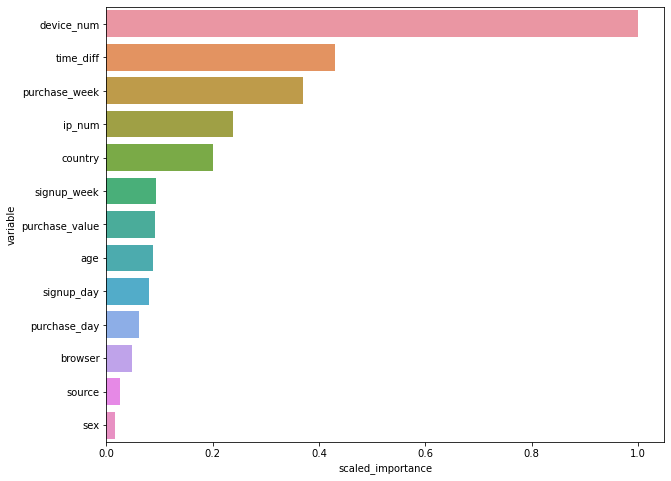

In [98]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()


In [110]:
# Make predictions 
train_true = train.as_data_frame()['class'].values
test_true = test.as_data_frame()['class'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [111]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41088
           1       1.00      0.53      0.69      4245

    accuracy                           0.96     45333
   macro avg       0.98      0.76      0.83     45333
weighted avg       0.96      0.96      0.95     45333



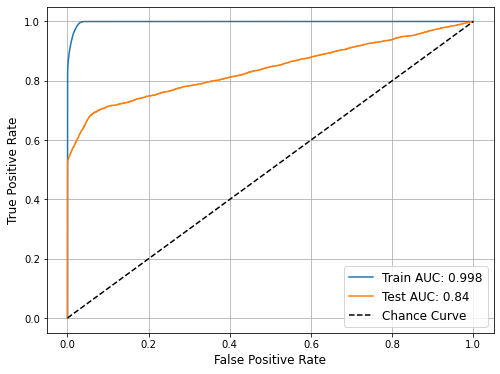

In [112]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()


Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero (this was essentially the random forest output). However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up).

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


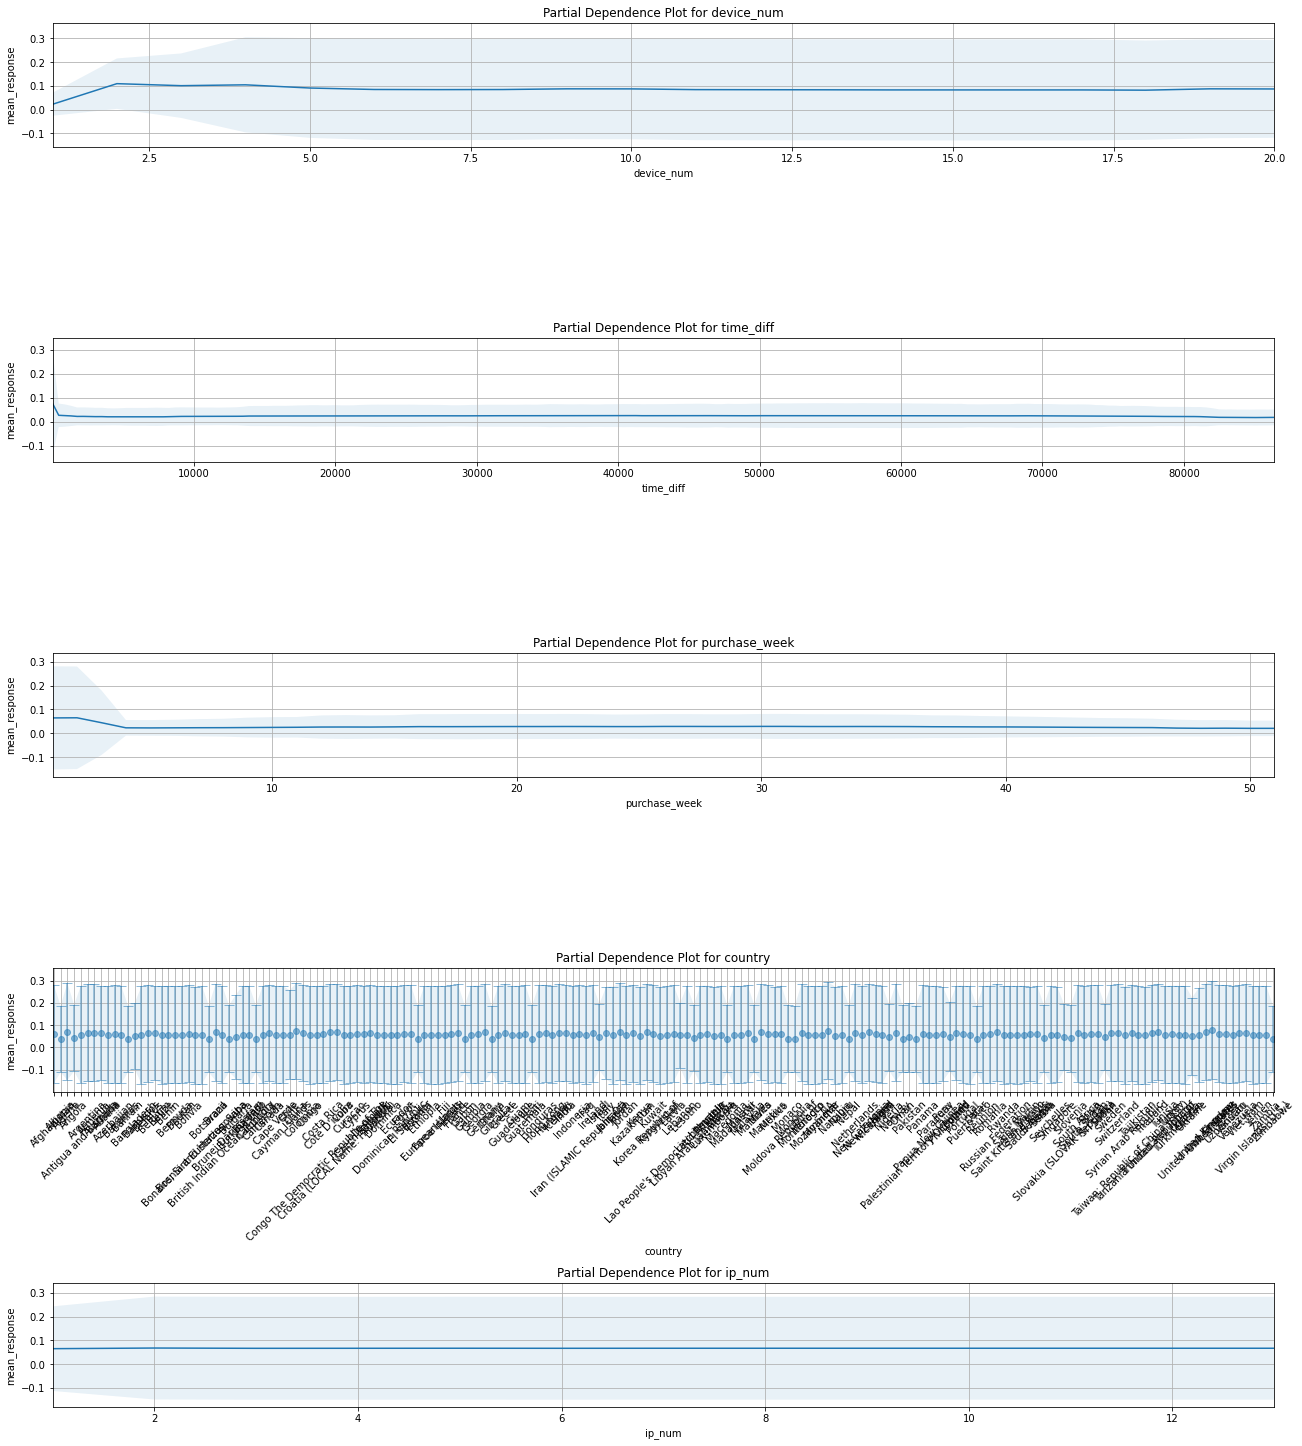

In [113]:
cols = ['device_num', 'time_diff', 'purchase_week', 'country', 'ip_num']
_ = model.partial_plot(data=train, cols=cols, nbins=200, figsize=(18, 20))

In [114]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_8b46 closed.
